# 7054-12-300-l_drucker_se_su_st_st_512_32

## Convert directory structure from synthnet evaluation pipeline format to Huggingface format

### Training Split

In [ ]:
import os
import shutil
from datasets import load_dataset
# load a local dataset from image directory (huggingface)
# https://huggingface.co/docs/datasets/image_dataset
DATASET_TRAIN_NAME = 'visda2017'
DS_TRAIN_DIR = f'/home/dritter/projects/evaluation-pipeline/data/{DATASET_TRAIN_NAME}/train/'
OUT_ROOT_TRAIN = f'data/{DATASET_TRAIN_NAME}'
# DS_TRAIN_DIR = f'/home/dennis/Desktop/work/evaluation_pipeline_data/visda/train/{DATASET_TRAIN_NAME}'
# load the our data dir (evaluation pipeline format) 
# change directory structure 
#   from:   data/ds_name/images/class/mesh/images
#   to:     data/ds_name/images/class/images
for path, dns, fns in os.walk(DS_TRAIN_DIR):
    for fn in fns:
        split_path = path.split('/')
        label = split_path[-2]
        split = 'train'
        os.makedirs(f'{OUT_ROOT_TRAIN}/{label}', exist_ok=True)
        shutil.copy(f'{path}/{fn}', f'{OUT_ROOT_TRAIN}/{split}/{label}/{fn}')

# load cifar10 (only small portion for demonstration purposes) 
# train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# # split up training into training + validation
# splits = train_ds.train_test_split(test_size=0.1)
# train_ds = splits['train']
# val_ds = splits['test']

### Test Split

In [ ]:
import os
import shutil
from datasets import load_dataset
# load a local dataset from image directory (huggingface)
# https://huggingface.co/docs/datasets/image_dataset
DATASET_TEST_NAME = 'visda2017'
DS_TRAIN_DIR = f'data/{DATASET_TRAIN_NAME}/train'
DS_TEST_DIR = f'/home/dritter/projects/evaluation-pipeline/data/datasets/{DATASET_TEST_NAME}/val'
OUT_ROOT_TEST = f'data/{DATASET_TEST_NAME}/val'

# Get classes present in train dataset
TRAIN_CLASSES = os.listdir('data/visda2017/train')
print(TRAIN_CLASSES)

for path, dns, fns in os.walk(DS_TEST_DIR):
    for fn in fns:
        split_path = path.split('/')
        label = split_path[-1]
        if label in TRAIN_CLASSES:
            os.makedirs(f'{OUT_ROOT_TEST}/{label}', exist_ok=True)
            shutil.copy(f'{path}/{fn}', f'{OUT_ROOT_TEST}/{label}/{fn}')

# load cifar10 (only small portion for demonstration purposes) 
# train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# # split up training into training + validation
# splits = train_ds.train_test_split(test_size=0.1)
# train_ds = splits['train']
# val_ds = splits['test']

### Sanity check

In [ ]:
DATASET_TRAIN_NAME = '7054-12-300-l_drucker_se_su_st_st_512_32'
DATASET_TEST_NAME = 'topex-real-123_pb_256'
TRAIN_CLASSES = os.listdir(f"data/{DATASET_TRAIN_NAME}")
TEST_CLASSES = os.listdir(f"data/{DATASET_TEST_NAME}")

for c in TEST_CLASSES:
    if c not in TRAIN_CLASSES:
        print(c)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np



X = []
y =[]
for i in range(0,100):
    X.append(f"img_{i}")
    y.append(f"label_{i%5}")
print(X)
print(y)
X = np.array(X)
y = np.array(y)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    print("TRAIN_i:", train_index)
    print("TEST_i:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
print("TRAIN", (X_train, y_train))
print("TEST", (X_test, y_test))

## Visda2017 test set (assign labels)

In [ ]:
import shutil
import os

data = 'data/visda2017/val'

for path, dns, fns in os.walk(data):
    for fn in fns:
        fn_split = fn.split('_')
        fn_split[1] = fn_split[1][:-4]
        new_fn = '_'.join(fn_split)
        shutil.move(f'{path}/{fn}', f'{path}/{new_fn}')

# Visda2017 MeshGrid



### Make Grid

In [2]:
import torchvision
import random
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision import transforms as transforms
import os
from PIL import Image

def grid(imps, grid_size = (4,4), cell_size=(64, 64), padding = 0 ):
    ims = [Image.open(imp) for imp in imps]
    transform = transforms.Compose([
        transforms.Resize(cell_size),
        transforms.PILToTensor()
    ])
    
    n_img = grid_size[0] * grid_size[1]
    ims_tensor = [transform(im) for im in ims]
    grid = make_grid(ims_tensor, nrow=grid_size[1], padding=padding)
    im_grid = torchvision.transforms.ToPILImage()(grid)
    return im_grid

In [ ]:
import shutil
import os
import pandas as pd
from PIL import Image, ImageOps

data = '/home/dritter/projects/evaluation-pipeline/data/datasets/visda2017/train/images'
out = 'data/visda2017_meshgrid'

d = {}
for path, dns, fns in os.walk(data):
    for fn in fns:
        pathsplit = path.split('/')
        label = pathsplit[-2]
        
        fnsplit = fn.split('__')
        mesh = fnsplit[0]
        angles = fnsplit[1].split('_')
        light_angle = angles[1]
        if f"{label}_{mesh}_{light_angle}" in d.keys():
            d[f"{label}_{mesh}_{light_angle}"].append(f"{path}/{fn}")
        else:
            d[f"{label}_{mesh}_{light_angle}"] = [f"{path}/{fn}"]
        
for key, val in d.items():
    val.sort()
    imgrid = grid(val[:16], cell_size=(48,48))
    imgrid = ImageOps.expand(imgrid, border=(16,16,16,16), fill="white")
    label = key.split('_')[0]
    out_dir = f"{out}/{label}"
    os.makedirs(out_dir,exist_ok=True)
    imgrid.save(f"{out_dir}/{key}_train.png")
        

## ModelNet10 Meshgrid

In [18]:
import torchvision
import random
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision import transforms as transforms
import os
from PIL import Image, ImageOps

def grid(imps, grid_size = (4,4), cell_size=(64, 64), padding = 0 ):
    ims = [Image.open(imp) for imp in imps]
    transform = transforms.Compose([
        transforms.Resize(cell_size),
        transforms.PILToTensor()
    ])
    
    n_img = grid_size[0] * grid_size[1]
    ims_tensor = [transform(im) for im in ims]
    grid = make_grid(ims_tensor, nrow=grid_size[1], padding=padding)
    im_grid = torchvision.transforms.ToPILImage()(grid)
    return im_grid

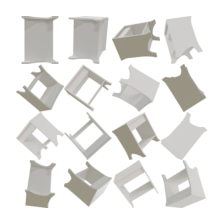

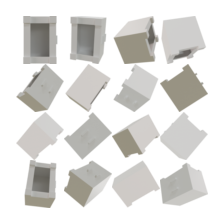

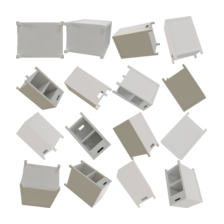

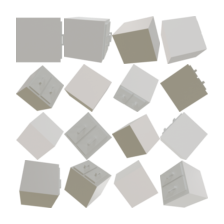

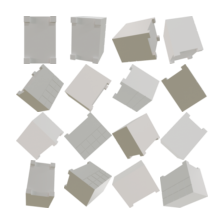

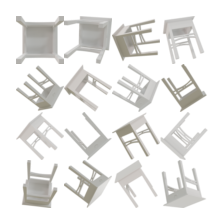

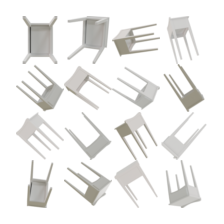

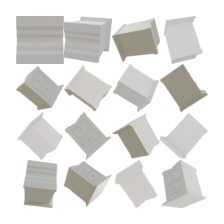

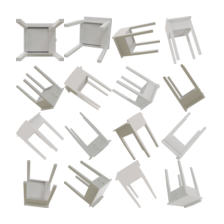

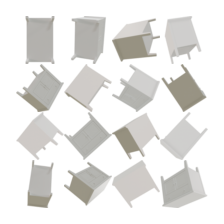

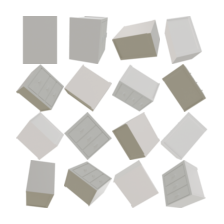

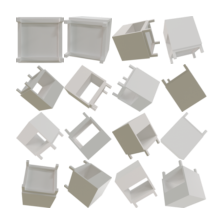

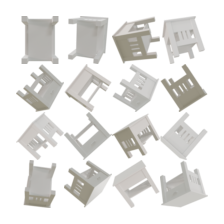

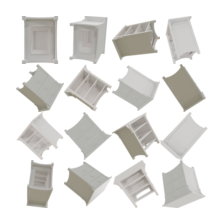

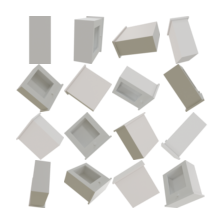

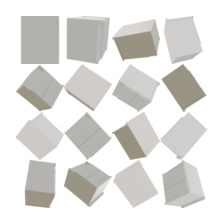

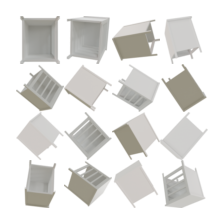

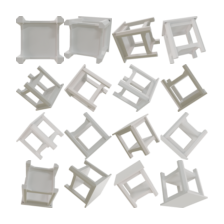

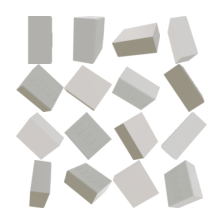

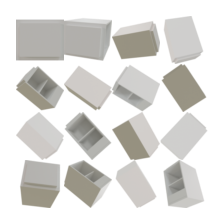

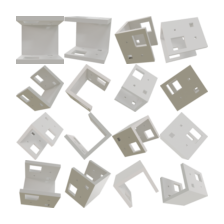

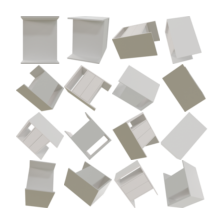

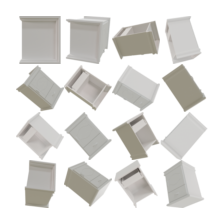

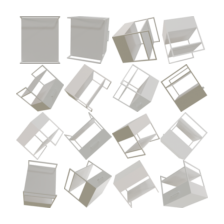

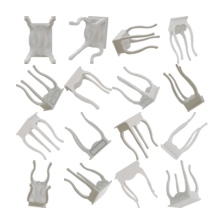

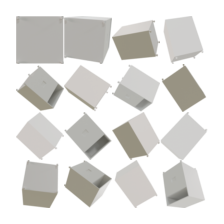

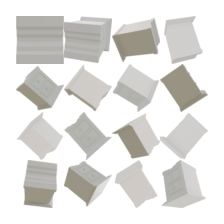

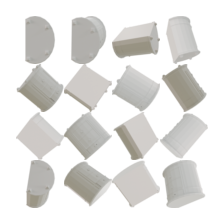

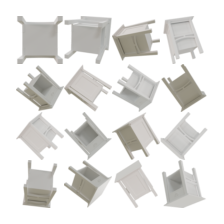

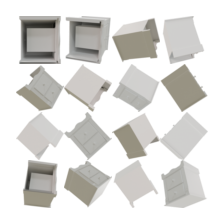

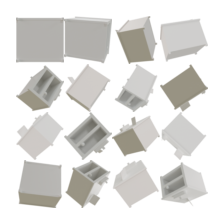

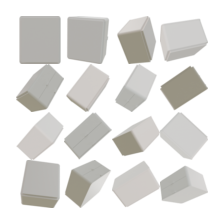

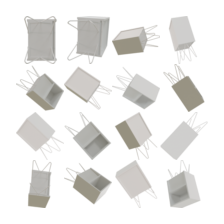

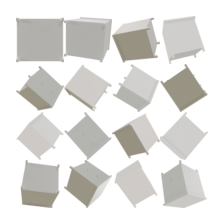

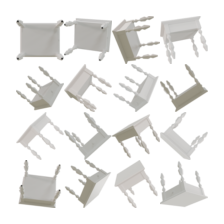

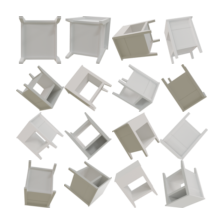

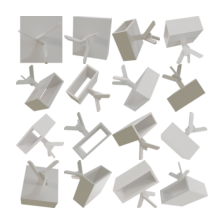

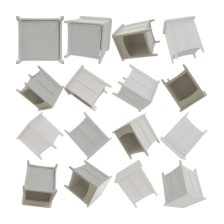

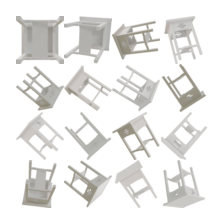

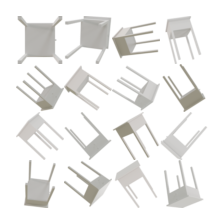

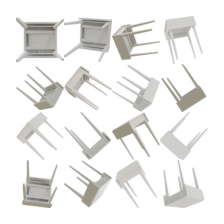

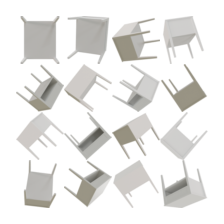

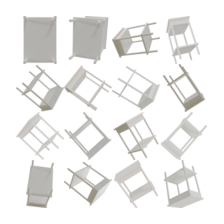

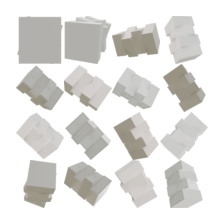

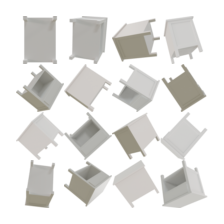

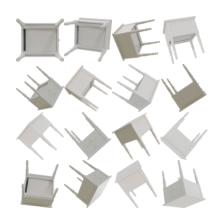

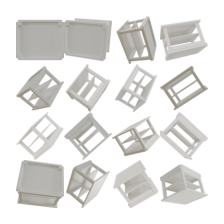

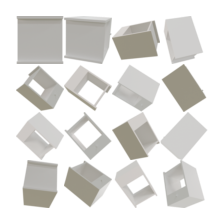

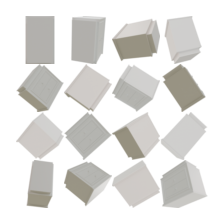

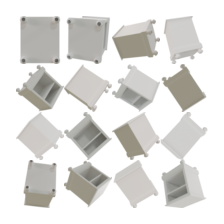

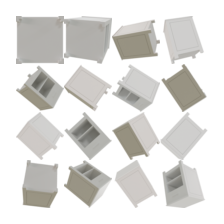

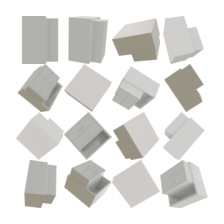

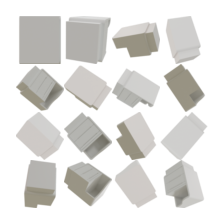

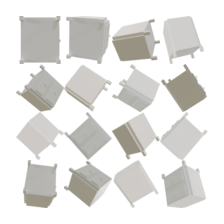

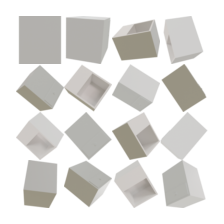

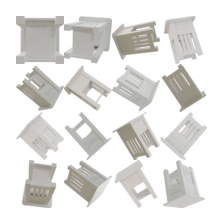

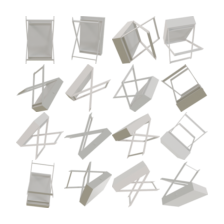

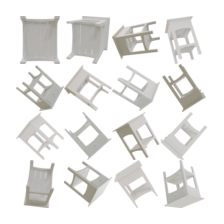

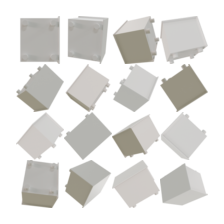

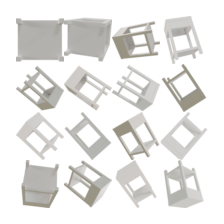

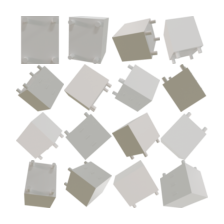

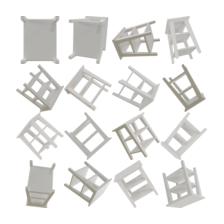

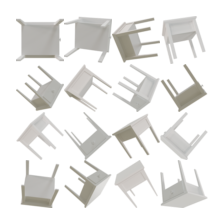

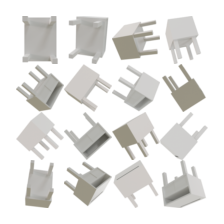

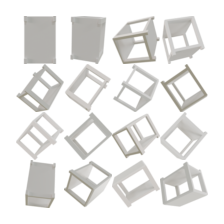

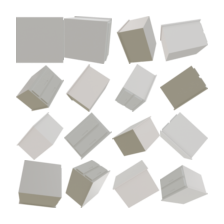

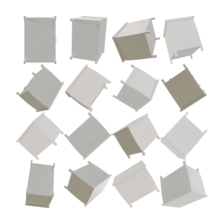

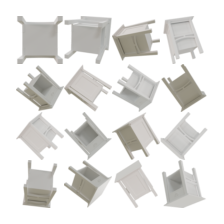

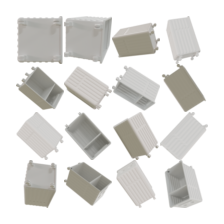

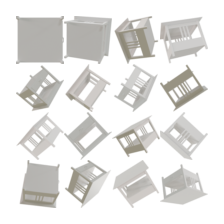

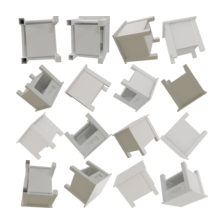

KeyboardInterrupt: 

In [19]:
import shutil
import os
import pandas as pd
from PIL import Image, ImageOps

data = 'data/modelnet10'
out = 'data/modelnet10_meshgrid'

d = {}
for path, dns, fns in os.walk(data):
    for fn in fns:
        pathsplit = path.split('/')
        split = pathsplit[-2]
        label = pathsplit[-1]
        
        fnsplit = fn.split('_')
        mesh = fnsplit[-2] 
        meshimage = fnsplit[-1].split('.')[0]
        key = f"{split}_{label}_{mesh}"
        if  key in d.keys():
            d[key].append(f"{path}/{fn}")
        else:
            d[key] = [f"{path}/{fn}"]
        
for key, val in d.items():
    val.sort()
    imgrid = grid(val[:16], cell_size=(48,48))
    imgrid = ImageOps.expand(imgrid, border=(16,16,16,16), fill="white")
    ksplit = key.split('_')
    split = ksplit[0]
    label = ksplit[1]
    if label == 'night':
        label += f"_{ksplit[2]}"
    mesh = ksplit[-1]
    out_dir = f"{out}/{split}/{label}/{label}_{mesh}"
    os.makedirs(out_dir,exist_ok=True)
    display(imgrid)
    # TODO: Make white bg
    # imgrid.save(f"{out_dir}/{split}_{label}_{mesh}.png")
        